In [1]:
#Import Libraries Here

#Base Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#Ml Libraries
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error , r2_score

In [2]:

#Neural Network
from keras.models import Sequential
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LSTM
# from scikeras.wrappers import KerasClassifier


# Third Iteration of our Fully Connected Neural Network- Higher Level Hyperparameter Tuning Attempt with Large Dataset
## Load Data 
with Expected_columns to get a cleaner data set to start

In [4]:
import glob
import pandas as pd

# Define the expected column names
expected_columns = ['Vehicle ID','Local Trip Start Time','Local Trip End Time','Total Distance','Idling Time','Driving Time','Total Run Time',
                    'Initial SOC','Final SOC','SOC Used','Total Energy Consumption','Average Ambient Temperature','Initial Odometer','Final Odometer',
                    'Max SOC','Min SOC','Percent Idling Time','Drive Cycle','Energy Consumed While Driving','Energy Consumed While Idling',	'Average Speed',
                    'Maximum Speed']		  # Replace with your actual column names

# List all CSV files in a directory
csv_files = glob.glob('vehicle/*.csv')

# Function to process each CSV file
def process_csv(file):
    df = pd.read_csv(file)
    # Reorder columns to match the expected order, fill missing columns with NaN
    df = df.reindex(columns=expected_columns)
    return df

# Read, process, and concatenate the CSV files
combined_vehicle_df = pd.concat((process_csv(file) for file in csv_files), ignore_index=True)

# Save the combined DataFrame to a new CSV file
combined_vehicle_df.to_csv('combined_vehicle_output.csv', index=False)

# Data Exploration and Cleaning

In [6]:
combined_vehicle_copy=combined_vehicle_df.copy()
combined_vehicle_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79903 entries, 0 to 79902
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Vehicle ID                     78585 non-null  object 
 1   Local Trip Start Time          33688 non-null  object 
 2   Local Trip End Time            33688 non-null  object 
 3   Total Distance                 72179 non-null  float64
 4   Idling Time                    51433 non-null  float64
 5   Driving Time                   60771 non-null  float64
 6   Total Run Time                 60254 non-null  float64
 7   Initial SOC                    40878 non-null  float64
 8   Final SOC                      41178 non-null  float64
 9   SOC Used                       65251 non-null  float64
 10  Total Energy Consumption       69594 non-null  float64
 11  Average Ambient Temperature    75026 non-null  object 
 12  Initial Odometer               36575 non-null 

In [7]:
# Replace 'NaN' strings with actual NaN values
combined_vehicle_copy = combined_vehicle_copy.replace('NaN', np.nan) # convert string NaN to nan
combined_vehicle_copy = combined_vehicle_copy.dropna(how='all') #  Removing Rows with All NaN Values
combined_vehicle_copy = combined_vehicle_copy.dropna(axis=1,how='all') #Removing Columns with all NaN Values

In [8]:
# Check for duplice data based on the vehical ID and the start time stamp
# Group by 'Local Trip Start Time' and count unique 'Vehicle ID' entries
unique_vehicle_per_time = combined_vehicle_copy.groupby('Local Trip Start Time')['Vehicle ID'].nunique()

# Check if any 'Local Trip Start Time' has more than one unique 'Vehicle ID'
multiple_vehicle_ids = unique_vehicle_per_time[unique_vehicle_per_time > 1]

if multiple_vehicle_ids.empty:
    print("Each Local Trip Start Time has only one Vehicle ID.")
else:
    print("There are Local Trip Start Times with more than one Vehicle ID:")
    print(multiple_vehicle_ids)


There are Local Trip Start Times with more than one Vehicle ID:
Local Trip Start Time
01/02/2023 04:16:00    2
01/02/2023 16:23:00    2
01/03/2023 04:38:00    2
01/04/2022 06:07       2
01/04/2023 05:58:00    2
                      ..
9/6/18 2:42 PM         2
9/6/18 6:33 PM         2
9/7/18 10:14 AM        2
9/7/18 6:55 PM         2
9/9/18 5:23 PM         2
Name: Vehicle ID, Length: 756, dtype: int64


In [9]:
# Display duplicate rows
duplicate_rows = combined_vehicle_copy[combined_vehicle_copy.duplicated()]
duplicate_rows['Vehicle ID'].count()

2654

In [10]:
# Remove duplicate rows
combined_vehicle_copy = combined_vehicle_copy.drop_duplicates()

# Confirm removal
print(f"DataFrame after removing duplicates has {len(combined_vehicle_copy)} rows.")

DataFrame after removing duplicates has 75931 rows.


In [11]:
#Remove EV for Vehicle ID and covert the reset to int for the Correlation table
combined_vehicle_copy['Vehicle ID']= combined_vehicle_copy['Vehicle ID'].str.replace('EV','',regex=False).astype(int)

In [12]:
import pandas as pd

# Fix issues and re-run conversion
combined_vehicle_copy['Local Trip Start Time'] = pd.to_datetime(combined_vehicle_copy['Local Trip Start Time'], errors='coerce')
combined_vehicle_copy['Local Trip End Time'] = pd.to_datetime(combined_vehicle_copy['Local Trip End Time'], errors='coerce')

# Extract date and time into separate columns
combined_vehicle_copy['date'] = combined_vehicle_copy['Local Trip Start Time'].dt.date
combined_vehicle_copy['Charging Start Time'] = combined_vehicle_copy['Local Trip Start Time'].dt.time
combined_vehicle_copy['Charging End Time'] = combined_vehicle_copy['Local Trip End Time'].dt.time


C:\Users\marieo3\AppData\Local\Temp\ipykernel_40396\2108580737.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_vehicle_copy['Local Trip Start Time'] = pd.to_datetime(combined_vehicle_copy['Local Trip Start Time'], errors='coerce')
C:\Users\marieo3\AppData\Local\Temp\ipykernel_40396\2108580737.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_vehicle_copy['Local Trip End Time'] = pd.to_datetime(combined_vehicle_copy['Local Trip End Time'], errors='coerce')


In [13]:
# Sort by Vehicle ID and Date_only to ensure order before counting
combined_vehicle_copy = combined_vehicle_copy.sort_values(by=['Vehicle ID', 'date'])

# Group by Vehicle ID and then use cumcount() + 1 to populate the Number of Trips column
combined_vehicle_copy['Number of Trips'] = combined_vehicle_copy.groupby('Vehicle ID').cumcount() + 1

In [14]:
combined_vehicle_copy['Energy Per Distance']=combined_vehicle_copy['Total Energy Consumption']/(combined_vehicle_copy['Total Distance'])

In [15]:
# Apply the missing data filling code here
# Ensure the data is sorted by 'Vehicle ID' and 'Date_only'
combined_vehicle_copy = combined_vehicle_copy.sort_values(by=['Vehicle ID', 'date'])

# Fill missing Initial Odometer with the previous row's Final Odometer
combined_vehicle_copy['Initial Odometer'] = combined_vehicle_copy['Initial Odometer'].fillna(
    combined_vehicle_copy.groupby('Vehicle ID')['Final Odometer'].shift(1)
)

# Fill missing Final Odometer with the next row's Initial Odometer
combined_vehicle_copy['Final Odometer'] = combined_vehicle_copy['Final Odometer'].fillna(
    combined_vehicle_copy.groupby('Vehicle ID')['Initial Odometer'].shift(-1)
)

In [16]:
# Fill in missing Total Run Time by summing Idling Time and Driving Time
combined_vehicle_copy['Total Run Time'] = combined_vehicle_copy.apply(
    lambda row: row['Idling Time'] + row['Driving Time'] if pd.isna(row['Total Run Time']) else row['Total Run Time'],
    axis=1
)

# Fill in missing Driving Time by subtracting Idling Time from Total Run Time
combined_vehicle_copy['Driving Time'] = combined_vehicle_copy.apply(
    lambda row: row['Total Run Time'] - row['Idling Time'] if pd.isna(row['Driving Time']) else row['Driving Time'],
    axis=1
)

# Fill in missing Idling Time by subtracting Driving Time from Total Run Time
combined_vehicle_copy['Idling Time'] = combined_vehicle_copy.apply(
    lambda row: row['Total Run Time'] - row['Driving Time'] if pd.isna(row['Idling Time']) else row['Idling Time'],
    axis=1
)

In [17]:
# Calculate Percent Idling Time where both Idling Time and Total Run Time are available
combined_vehicle_copy['Percent Idling Time'] = (combined_vehicle_copy['Idling Time'] / combined_vehicle_copy['Total Run Time'])

In [18]:
# Replace 'NaN' strings with actual NaN values
combined_vehicle_copy = combined_vehicle_copy.replace('NaN', np.nan) # convert string NaN to nan
#combined_vehicle_copy = combined_vehicle_copy.replace('NaT', np.nan) # convert string NaT to nan', np
combined_vehicle_copy = combined_vehicle_copy.dropna(how='all') #  Removing Rows with All NaN Values
combined_vehicle_copy = combined_vehicle_copy.dropna(axis=1,how='all') #Removing Columns with all NaN Values

In [19]:
combined_vehicle_=combined_vehicle_copy.copy()

In [20]:
# List of columns to fill based on the mean of Vehicle ID
columns_to_fill = [
    'Local Trip Start Time', 'Local Trip End Time', 'Total Distance', 
    'Idling Time', 'Driving Time', 'Total Run Time', 'Initial SOC', 
    'Final SOC', 'SOC Used', 'Total Energy Consumption', 
    'Initial Odometer', 'Final Odometer', 'Max SOC', 
    'Min SOC', 'Percent Idling Time', 'Energy Consumed While Driving', 
    'Energy Consumed While Idling', 'Average Speed', 'Maximum Speed', 
    'Energy Per Distance'
]

# Fill missing values for each column based on mean per Vehicle ID
for col in columns_to_fill:
    if col in combined_vehicle_.columns:
        # Compute mean within each Vehicle ID group
        mean_per_id = combined_vehicle_.groupby('Vehicle ID')[col].transform('mean')
        
        # Fill missing values in the column
        combined_vehicle_[col] = combined_vehicle_[col].fillna(mean_per_id)

# Print results
print("Missing values filled based on Vehicle ID group mean.")


Missing values filled based on Vehicle ID group mean.


In [21]:
combined_vehicle_=combined_vehicle_.drop([ 'Local Trip Start Time','Local Trip End Time','Drive Cycle','Max SOC','Min SOC','date','Charging Start Time','Charging End Time','Energy Consumed While Driving','Energy Consumed While Idling','Average Speed','Maximum Speed'],axis=1)
combined_vehicle_ = combined_vehicle_.replace([np.inf, -np.inf], np.nan)
combined_vehicle_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75931 entries, 0 to 79902
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Vehicle ID                   75931 non-null  int32  
 1   Total Distance               75931 non-null  float64
 2   Idling Time                  52450 non-null  float64
 3   Driving Time                 62752 non-null  float64
 4   Total Run Time               64845 non-null  float64
 5   Initial SOC                  44992 non-null  float64
 6   Final SOC                    44992 non-null  float64
 7   SOC Used                     71578 non-null  float64
 8   Total Energy Consumption     75649 non-null  float64
 9   Average Ambient Temperature  73156 non-null  object 
 10  Initial Odometer             40221 non-null  float64
 11  Final Odometer               40221 non-null  float64
 12  Percent Idling Time          52450 non-null  float64
 13  Number of Trips      

# Visualize the Data

In [23]:
#Copying data for model
#fcnn_model_data = dropped_objects_df.copy()
fcnn_model_data = combined_vehicle_
#Removing all rows with NaN
fcnn_model_data.dropna(inplace=True)

fcnn_model_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26051 entries, 1483 to 78545
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Vehicle ID                   26051 non-null  int32  
 1   Total Distance               26051 non-null  float64
 2   Idling Time                  26051 non-null  float64
 3   Driving Time                 26051 non-null  float64
 4   Total Run Time               26051 non-null  float64
 5   Initial SOC                  26051 non-null  float64
 6   Final SOC                    26051 non-null  float64
 7   SOC Used                     26051 non-null  float64
 8   Total Energy Consumption     26051 non-null  float64
 9   Average Ambient Temperature  26051 non-null  object 
 10  Initial Odometer             26051 non-null  float64
 11  Final Odometer               26051 non-null  float64
 12  Percent Idling Time          26051 non-null  float64
 13  Number of Trips   

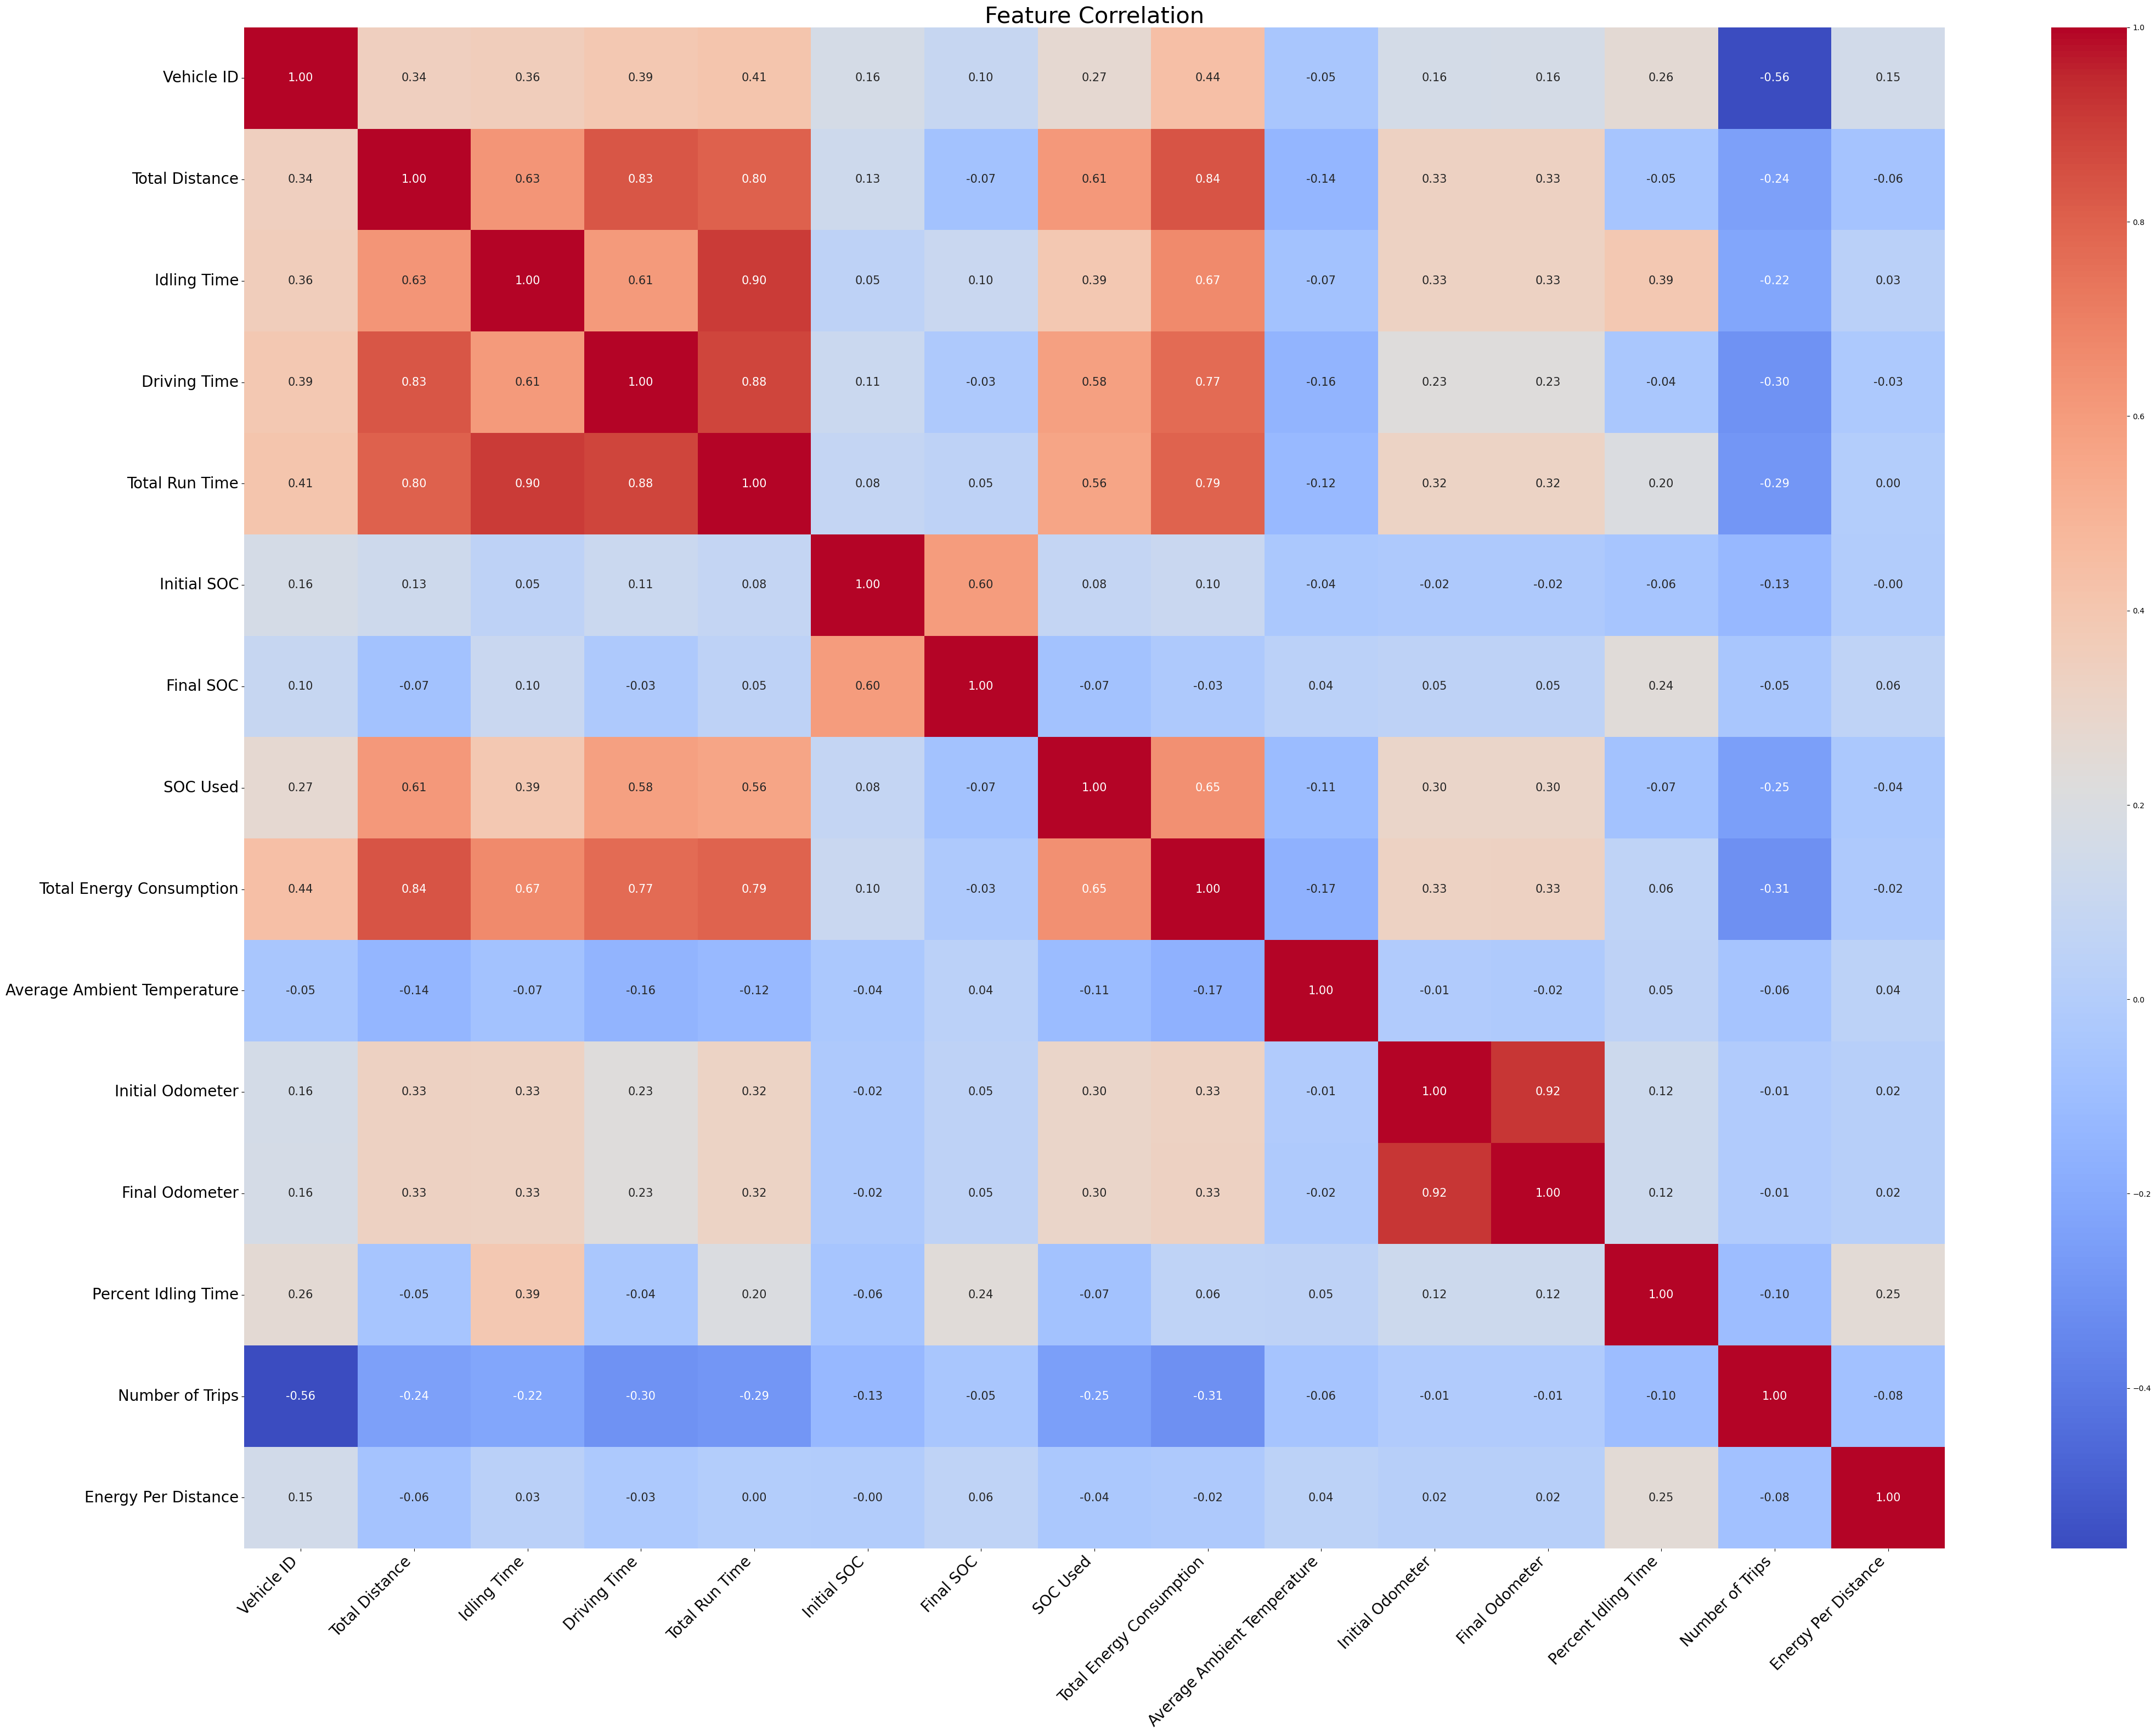

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(50, 36))

# Increase text size for annotations
sns.heatmap(
    fcnn_model_data.corr(),
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    annot_kws={"size": 15}  # Adjust annotation font size
)

# Increase title and axis label font sizes
plt.title('Feature Correlation', fontsize=30)  # Adjust title font size
plt.xticks(fontsize=20,rotation=45, ha='right')  # Adjust x-axis tick font size
plt.yticks(fontsize=20)  # Adjust y-axis tick font size

plt.show()

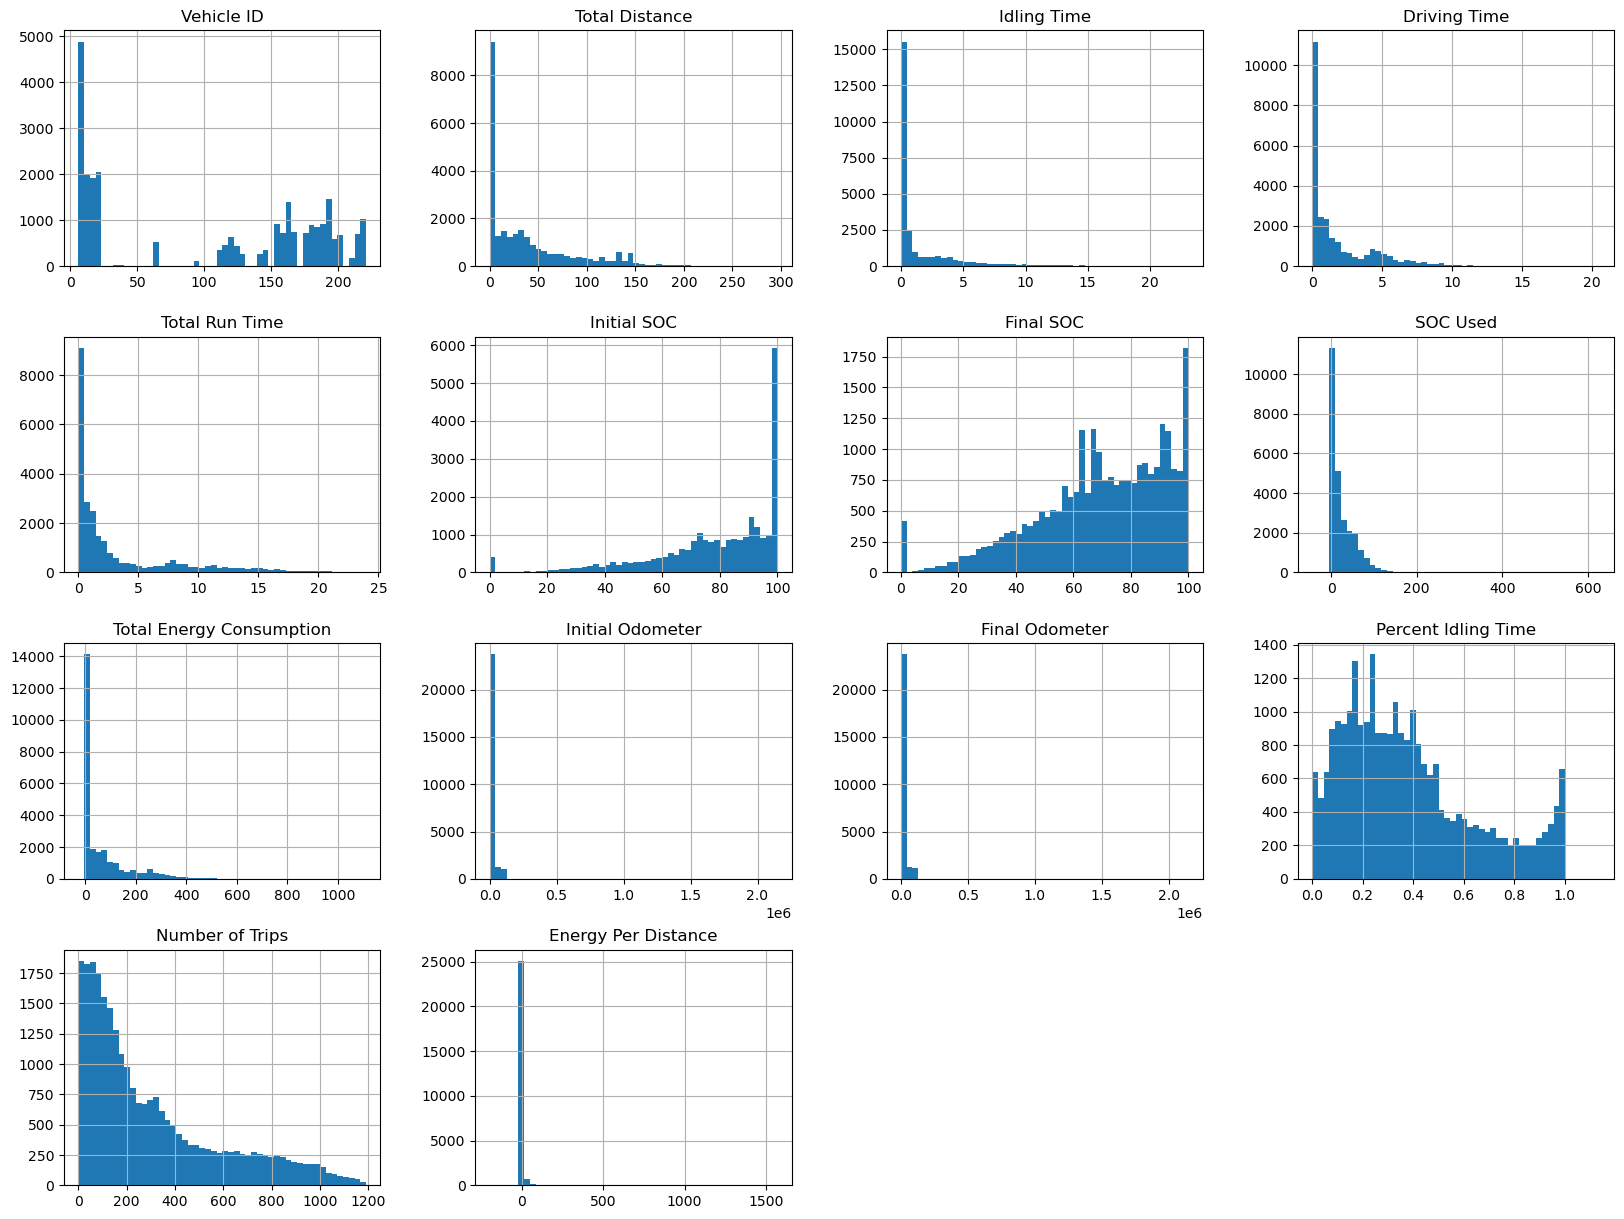

In [25]:
import matplotlib.pyplot as plt
fcnn_model_data.hist(bins=50, figsize=(20,15))
plt.show()

In [26]:

# Drop outliers for Total Energy Consumption (Anything 800 or higher and less than 0
fcnn_model_data = fcnn_model_data[(fcnn_model_data["Total Energy Consumption"] < 800) & 
                                   (fcnn_model_data["Total Energy Consumption"] > 0)] 
fcnn_model_data.shape

(25762, 15)

In [27]:
#from sklearn.preprocessing import QuantileTransformer
#transformer = QuantileTransformer(output_distribution='normal')
#fcnn_model_data['Total Energy Consumption'] = transformer.fit_transform(fcnn_model_data[['Total Energy Consumption']])

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Separate features (X) and target (y)
X = fcnn_model_data.drop(columns=['Total Energy Consumption'])
y = fcnn_model_data['Total Energy Consumption']

# Apply log transformation to the target variable to reduce skewness
y = np.log1p(y)  # log1p ensures log(0) is handled correctly

# First, split into train + validation and test
X_temp, X_test_FCNN, y_temp, y_test_FCNN = train_test_split(X, y, test_size=0.2, random_state=42)

# Then split train + validation into train and validation
X_train_FCNN, X_val_FCNN, y_train_FCNN, y_val_FCNN = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
# 0.25 x 0.8 = 0.2 (20% of the total data for validation)

print(f"Training set: {len(X_train_FCNN)} samples")
print(f"Validation set: {len(X_val_FCNN)} samples")
print(f"Test set: {len(X_test_FCNN)} samples")

# Standardize the feature data
scaler = StandardScaler()

# Fit/transform the training data and transform validation and test data
X_train_FCNN = scaler.fit_transform(X_train_FCNN)
X_val_FCNN = scaler.transform(X_val_FCNN)
X_test_FCNN = scaler.transform(X_test_FCNN)

# Output the shapes to verify
print(f"X_train_FCNN shape: {X_train_FCNN.shape}")
print(f"X_val_FCNN shape: {X_val_FCNN.shape}")
print(f"X_test_FCNN shape: {X_test_FCNN.shape}")


Training set: 15456 samples
Validation set: 5153 samples
Test set: 5153 samples
X_train_FCNN shape: (15456, 14)
X_val_FCNN shape: (5153, 14)
X_test_FCNN shape: (5153, 14)


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam

def build_model(optimizer='adam', learning_rate=0.001, neurons=64, dropout_rate=0.3, **kwargs):
    model = Sequential()

    # Input and first hidden layer
    model.add(Dense(neurons, activation='relu', input_shape=(X_train_FCNN.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Second hidden layer
    model.add(Dense(int(neurons / 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(max(dropout_rate - 0.1, 0.2)))  # Ensuring dropout rate doesn't go below 0.2

    # Third hidden layer
    model.add(Dense(int(neurons / 4), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(max(dropout_rate - 0.2, 0.2)))

    # Fourth hidden layer
    model.add(Dense(int(neurons / 8), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(max(dropout_rate - 0.3, 0.2)))

    # Output layer
    model.add(Dense(1, activation='linear'))  # 'linear' for regression

    # Optimizer initialization
    if optimizer == 'adam':
        optimizer_instance = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer_instance = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer_instance = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'nadam':
        optimizer_instance = Nadam(learning_rate=learning_rate)
    else:
        raise ValueError("Optimizer not recognized. Use 'adam', 'sgd', 'rmsprop', or 'nadam'.")
    
    model.compile(optimizer=optimizer_instance, loss='mse', metrics=['mae'])

    return model


In [30]:
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import SGD, RMSprop, Adam,  Nadam

# Wrap the model with KerasRegressor and specify custom parameters
model = KerasRegressor(model=build_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'model__optimizer': ['adam', 'sgd', 'rmsprop', 'nadam'],
    'model__learning_rate': [0.001, 0.0005, 0.0001],
    'model__neurons': [32, 64, 128,256,512],
    'model__dropout_rate': [0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9],
    'fit__epochs': [10,20,50, 100,150,200],
    'fit__batch_size': [16, 32, 64,128]
}

In [31]:
# Set up random search with 3-fold cross-validation
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_grid,
                                   n_iter=20,  # Number of random combinations to try
                                   cv=3,
                                   verbose=1,
                                   n_jobs=-1)  # Use all available cores
# Run the random search
random_search_result = random_search.fit(X_train_FCNN, y_train_FCNN)

# Display best hyperparameters and score
print("Best Hyperparameters:", random_search_result.best_params_)
print("Best Score:", random_search_result.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\marieo3\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Hyperparameters: {'model__optimizer': 'nadam', 'model__neurons': 256, 'model__learning_rate': 0.0005, 'model__dropout_rate': 0.5, 'fit__epochs': 150, 'fit__batch_size': 64}
Best Score: 0.9677305710083782


### FCNN

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop  # Import the optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Extract the best hyperparameters
best_params = random_search_result.best_params_
optimizer_str = best_params['model__optimizer']
learning_rate = float(best_params['model__learning_rate'])  # Convert to float
neurons = int(best_params['model__neurons'])  # Convert to int
dropout_rate = float(best_params['model__dropout_rate'])  # Convert to float
epochs = int(best_params['fit__epochs'])  # Convert to int
batch_size = int(best_params['fit__batch_size'])  # Convert to int

# Map string optimizer to actual optimizer class
optimizer_dict = {
    'adam': Adam,
    'sgd': SGD,
    'rmsprop': RMSprop,
    'nadam': Nadam
}

# Initialize the model
model = Sequential()

# Input and first hidden layer
model.add(Dense(neurons, activation='relu', input_shape=(X_train_FCNN.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

 # Second hidden layer
model.add(Dense(int(neurons / 2), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate - 0.1))

# Third hidden layer
model.add(Dense(int(neurons / 4), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate - 0.2))

# Fourth hidden layer
model.add(Dense(int(neurons / 8), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate - 0.3))

# Output layer
model.add(Dense(1, activation='linear'))

# Compile the model with the dynamically selected optimizer and learning rate
optimizer_instance = optimizer_dict[optimizer_str](learning_rate=learning_rate)
model.compile(optimizer=optimizer_instance, loss='mse', metrics=['mae'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=10,        # Wait for 10 epochs without improvement
                               restore_best_weights=True,  # Restore the best weights when training stops
                               verbose=1)

# Train the model with early stopping
history = model.fit(X_train_FCNN, y_train_FCNN,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test_FCNN, y_test_FCNN),
                    verbose=1,
                    callbacks=[early_stopping])  # Pass early stopping callback

# Evaluation using loss and mae
loss, mae = model.evaluate(X_test_FCNN, y_test_FCNN, verbose=1)


C:\Users\marieo3\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 9.7986 - mae: 2.7069 - val_loss: 4.1569 - val_mae: 1.7069
Epoch 2/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.2428 - mae: 1.7458 - val_loss: 0.9265 - val_mae: 0.7586
Epoch 3/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.8720 - mae: 1.0840 - val_loss: 0.4123 - val_mae: 0.4628
Epoch 4/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3480 - mae: 0.9039 - val_loss: 0.3623 - val_mae: 0.3999
Epoch 5/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1013 - mae: 0.8144 - val_loss: 0.3265 - val_mae: 0.3760
Epoch 6/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9384 - mae: 0.7531 - val_loss: 0.3210 - val_mae: 0.3722
Epoch 7/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8476 - mae: 0.7088 - val_loss: 0.2940 - val_mae: 0.3548
Epoch 8/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7201 - mae: 0.6557 - val_loss: 0.2932 - val_mae: 0.3515
Epoch 9/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/

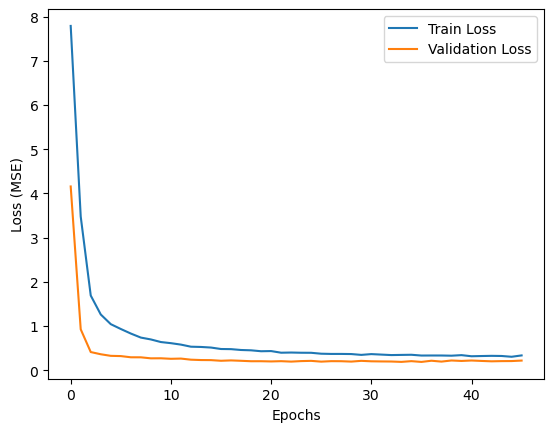

In [86]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [88]:
#Creating predictions
y_pred_FCNN = model.predict(X_test_FCNN)
y_pred_FCNN_clipped = np.clip(y_pred_FCNN.flatten(), 0, None)

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


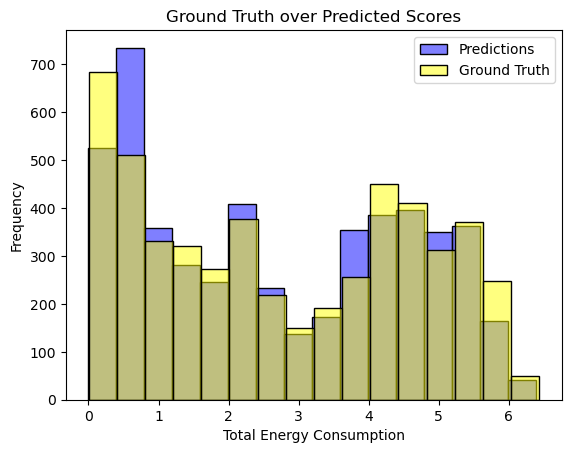

In [90]:


#Ground Truth Score histogram overlayed on Predicted Scores
sns.histplot(y_pred_FCNN_clipped, color='blue', alpha=0.5, kde=False, label='Predictions')
sns.histplot(y_test_FCNN, color='yellow', alpha=0.5, kde=False, label='Ground Truth')

plt.xlabel('Total Energy Consumption')
plt.ylabel('Frequency')
plt.title('Ground Truth over Predicted Scores')
plt.legend()

plt.show()

In [92]:
import lime
from lime.lime_tabular import LimeTabularExplainer

# Initialize the explainer
explainer = LimeTabularExplainer(X_train_FCNN,
                                 mode="regression",
                                 training_labels=y_train_FCNN,
                                 feature_names=fcnn_model_data.drop(columns=['Total Energy Consumption']).columns,  # Replace 'target' as appropriate
                                 discretize_continuous=True)

# Select a sample for explanation

# Select a sample for explanation
i = 18  # Index of the sample to explain
sample = X_test_FCNN[i].reshape(1, -1) # Single sample as NumPy array

# Generate the explanation
explanation = explainer.explain_instance(sample.flatten(),
                                         model.predict,  # Pass the prediction function
                                         num_features=23)  # Number of features to include in explanation

# Show the explanation
table_html=explanation.show_in_notebook()  # Displays the explanation in Jupyter Notebook

# Configure pandas to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Display the HTML
display(table_html)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


None

In [94]:
import lime
from lime.lime_tabular import LimeTabularExplainer

# Initialize the explainer
explainer = LimeTabularExplainer(X_train_FCNN,
                                 mode="regression",
                                 training_labels=y_train_FCNN,
                                 feature_names=fcnn_model_data.drop(columns=['Total Energy Consumption']).columns,  # Replace 'target' as appropriate
                                 discretize_continuous=True)

# Select a sample for explanation

# Select a sample for explanation
i = 1  # Index of the sample to explain
sample = X_test_FCNN[i].reshape(1, -1) # Single sample as NumPy array

# Generate the explanation
explanation = explainer.explain_instance(sample.flatten(),
                                         model.predict,  # Pass the prediction function
                                         num_features=23)  # Number of features to include in explanation

# Show the explanation
table_html=explanation.show_in_notebook()  # Displays the explanation in Jupyter Notebook

# Configure pandas to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Display the HTML
display(table_html)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


None

In [96]:
import numpy as np
import pandas as pd

# Predict on test data
y_pred_FCNN = model.predict(X_test_FCNN)

# For regression, ensure predictions are properly constrained (optional)
y_pred_FCNN_clipped = np.clip(y_pred_FCNN.flatten(), 0, None)

# Create correction table
correction_table = pd.DataFrame({
    'True Value': y_test_FCNN,
    'Predicted Value': y_pred_FCNN_clipped,
    'Error': np.abs(y_test_FCNN - y_pred_FCNN_clipped)
})

# Display top errors
print(correction_table.sort_values(by='Error', ascending=False).head(10))


162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
       True Value  Predicted Value     Error
64954    4.764881         0.000000  4.764881
48606    5.103829         0.704685  4.399144
50017    5.389741         1.606055  3.783686
49291    5.267731         1.575291  3.692440
77699    4.854179         1.312895  3.541284
65271    6.229694         2.859384  3.370309
48930    4.599886         1.232830  3.367056
48933    4.599886         1.341137  3.258749
49357    4.586847         1.348905  3.237942
49449    4.586847         1.366955  3.219892


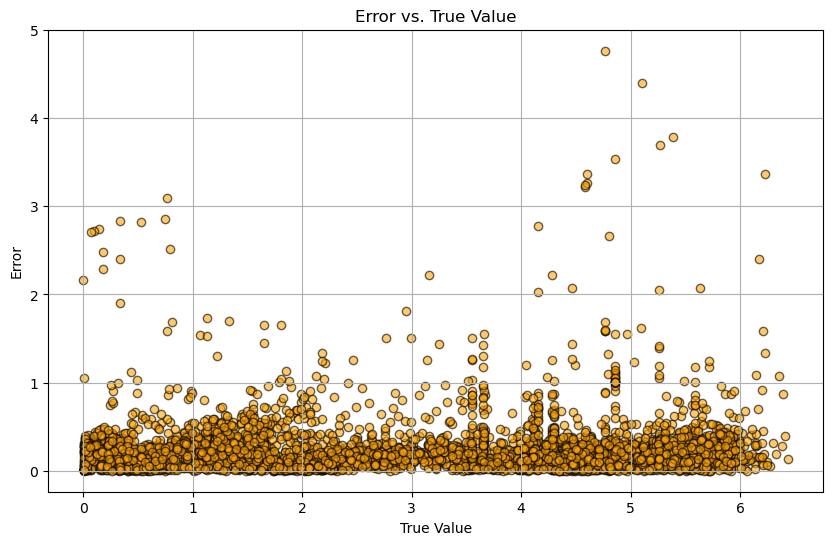

In [98]:
plt.figure(figsize=(10, 6))
plt.scatter(correction_table['True Value'], correction_table['Error'], alpha=0.6, color='orange', edgecolors='k')
plt.xlabel('True Value')
plt.ylabel('Error')
plt.title('Error vs. True Value')
plt.grid(True)
plt.show()

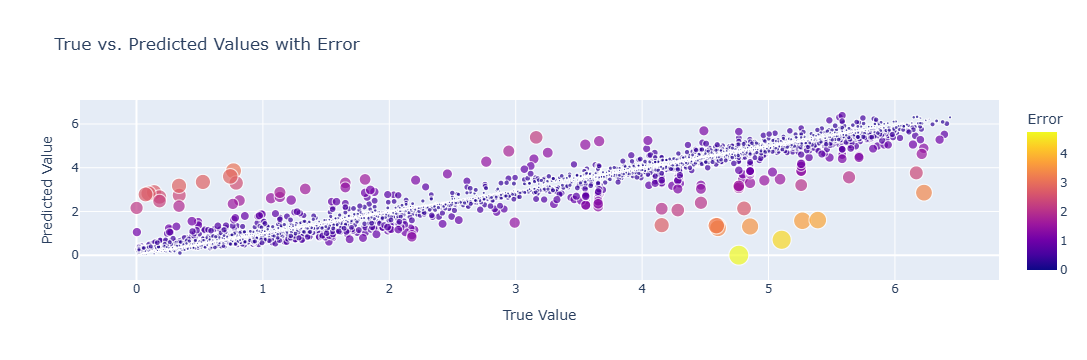

In [100]:
import plotly.express as px

# Interactive scatter plot
fig = px.scatter(correction_table, x='True Value', y='Predicted Value', 
                 size='Error', color='Error', 
                 title='True vs. Predicted Values with Error',
                 labels={'True Value': 'True Value', 'Predicted Value': 'Predicted Value'})
fig.show()